In [1]:
import dgl
import torch
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import conv as dgl_conv
from dgl import backend as dgl_F

Using backend: pytorch


In [3]:
from cell import utils, graph_utils, plot_utils
from dgl import DGLGraph

### Read all the interactions and concat them

In [4]:
all_layers = utils.get_npp_visp_layers()
all_int_mat = np.zeros((93,93))

for l in all_layers:
    intraction_matrix_filename = utils.get_intraction_matrix_filename(roi= "VISp",
                                                                      layer= l,
                                                                      project_name= "NPP_GNN_project")

    all_int_mat = all_int_mat + np.array(pd.read_csv(intraction_matrix_filename , index_col="Unnamed: 0"))
    

In [5]:
all_int_mat = pd.DataFrame(all_int_mat)
new_all_int_mat = np.zeros((93,93))
for r,c in all_int_mat.iterrows():
    sorted_vals = np.argsort(-all_int_mat[r])[0:5] 
    #random_index = np.random.randint(0, 93, size=5)
    for m in sorted_vals:
        new_all_int_mat[int(r)][m] = all_int_mat[r][m]
        

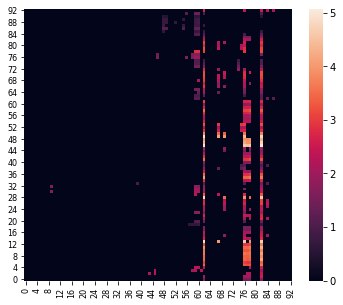

In [6]:
fig = plt.figure(figsize=(6,5))
ax = sns.heatmap(new_all_int_mat)
ax.tick_params(labelsize=8)
ax.invert_yaxis()

In [7]:
new_all_int_mat.shape

(93, 93)

## Build nx directed weighted graph

In [8]:
class NPPDataset(object):
    def __init__(self, edge_list, communication_df, self_loop=False):
        self_loop_str = ""
        if self_loop:
            self_loop_str = "_self_loop"
        
        # graph
        G = nx.DiGraph()
        G.add_weighted_edges_from([tuple(x) for x in edge_list.values])
        node_labels = [i for i in G.nodes]
        self.graph = dgl.DGLGraph()
        self.graph.from_networkx(G, edge_attrs=['weight']) 
        self.graph.readonly()
        
        #node features
        communication_df = communication_df.loc[node_labels][node_labels] 
        self.features = np.array(communication_df)
        self.labels = [int(i) for i in node_labels]
        self.num_labels = len(np.unique(node_labels))
        
        print('Finished data loading.')
        print('  NumNodes: {}'.format(self.graph.number_of_nodes()))
        print('  NumEdges: {}'.format(self.graph.number_of_edges()))
        print('  NumFeats: {}'.format(self.features.shape[1]))
        print('  NumClasses: {}'.format(self.num_labels))

    def __getitem__(self, idx):
        assert idx == 0, "NPP Dataset only has one graph"
        g = self.graph
        g.ndata['feat'] = self.features
        g.ndata['label'] = self.labels
        return g
    
    def __len__(self):
        return 1

In [9]:
def prepare_input(edge_list, communication_df):
    
    data = NPPDataset(edge_list=edge_list, 
                      communication_df=communication_df)
    
    features = torch.FloatTensor(data.features)
    in_feats = features.shape[1]
    labels = torch.LongTensor(data.labels)
    n_classes = data.num_labels
    g = data.graph
    return data, features, in_feats, labels, n_classes, g


mat = new_all_int_mat

communication_df = pd.DataFrame(mat, 
                                 index=[str(i) for i in range(mat.shape[0])],
                                 columns=[str(i) for i in range(mat.shape[0])])

edge_list = graph_utils.build_edge_list(communication_df, 
                                        threshold=None, 
                                        directed=True)
edge_list = edge_list[edge_list['weight']!=0] 

data, features, in_feats, labels, n_classes, g = prepare_input(
    edge_list=edge_list, 
    communication_df=communication_df)

Building a directed graph edge list
Finished data loading.
  NumNodes: 93
  NumEdges: 465
  NumFeats: 93
  NumClasses: 93


## Define graph convolution model

In [10]:
class GraphSAGEModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGEModel, self).__init__()
        self.layers = nn.ModuleList()

        # input layer
        self.layers.append(dgl_conv.SAGEConv(in_feats, n_hidden, aggregator_type,
                                         feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(dgl_conv.SAGEConv(n_hidden, n_hidden, aggregator_type,
                                             feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(dgl_conv.SAGEConv(n_hidden, out_dim, aggregator_type,
                                         feat_drop=dropout, activation=None))

    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = layer(g, h)
        return h

## Link prediction task

In [11]:
# NCE loss
def NCE_loss(pos_score, neg_score, neg_sample_size):
    pos_score = F.logsigmoid(pos_score)
    neg_score = F.logsigmoid(-neg_score).reshape(-1, neg_sample_size)
    return -pos_score - torch.sum(neg_score, dim=1)


class LinkPrediction(nn.Module):
    def __init__(self, gconv_model):
        super(LinkPrediction, self).__init__()
        self.gconv_model = gconv_model

    def forward(self, g, features, neg_sample_size):
        emb = self.gconv_model(g, features)
        pos_g, neg_g = edge_sampler(g, neg_sample_size, return_false_neg=False)
        pos_score = score_func(pos_g, emb)
        neg_score = score_func(neg_g, emb)
        return torch.mean(NCE_loss(pos_score, neg_score, neg_sample_size))

## Edge sampler

In [12]:
def edge_sampler(g, neg_sample_size, edges=None, return_false_neg=True, edge_weight=None):
    sampler = dgl.contrib.sampling.EdgeSampler(g, batch_size=int(g.number_of_edges()/10),
                                               seed_edges=edges,
                                               neg_sample_size=neg_sample_size,
                                               negative_mode='tail',
                                               shuffle=True,
                                               return_false_neg=return_false_neg)
    sampler = iter(sampler)
    return next(sampler)

In [13]:
# data, features, in_feats, labels, n_classes, g = prepare_input(pd.DataFrame(new_all_int_mat))
# train_eids, valid_eids, test_eids, train_g = prepare_train_test_valid(g)

In [14]:
# g.out_degrees()

In [15]:
# g.in_degrees()

In [16]:
# p1, n1 = edge_sampler(g, 1, torch.tensor([i for i in range(g.number_of_edges())]), edge_weight= g.edata['weight'])
# p2, n2 = edge_sampler(g, 1, torch.tensor([i for i in range(g.number_of_edges())]))

In [17]:
# p1

In [18]:
# p2

In [19]:
# n1

In [20]:
# n2

In [21]:
# g.edata['weight']

## Score function

In [22]:
def score_func(g, emb, parent_graph=False):
    src_nid, dst_nid = g.all_edges(order='eid')
    # Get the node Ids in the parent graph.
    if not parent_graph:
        src_nid = g.parent_nid[src_nid]
        dst_nid = g.parent_nid[dst_nid]
    # Read the node embeddings of the source nodes and destination nodes.
    pos_heads = emb[src_nid]
    pos_tails = emb[dst_nid]
    return torch.sum(pos_heads * pos_tails, dim=1)

## Evaluation

In [23]:
def LPEvaluate(gconv_model, g, features, eval_eids, neg_sample_size):
    gconv_model.eval()
    with torch.no_grad():
        emb = gconv_model(g, features)
        
        pos_g, neg_g = edge_sampler(g, neg_sample_size, eval_eids, return_false_neg=True)
        pos_score = score_func(pos_g, emb)
        neg_score = score_func(neg_g, emb).reshape(-1, neg_sample_size)
        filter_bias = neg_g.edata['false_neg'].reshape(-1, neg_sample_size)

        pos_score = F.logsigmoid(pos_score)
        neg_score = F.logsigmoid(neg_score)
        neg_score -= filter_bias.float()
        pos_score = pos_score.unsqueeze(1)
        rankings = torch.sum(neg_score >= (pos_score), dim=1) + 1
        return np.mean(1.0/rankings.cpu().numpy())

## Prepare train, validation and test

In [24]:
def get_edge_weights(g, eids):
    return [g.edata['weight'][idx].numpy().tolist() for idx in eids] 

In [25]:
def prepare_train_test_valid(g):
    eids = np.random.permutation(g.number_of_edges())
    train_eids = eids[:int(len(eids) * 0.8)]
    valid_eids = eids[int(len(eids) * 0.8):int(len(eids) * 0.9)]
    test_eids = eids[int(len(eids) * 0.9):]
    train_g = g.edge_subgraph(train_eids, preserve_nodes=True)
    train_g_edata = get_edge_weights(g, train_eids)
    train_g.edata['weight'] = torch.tensor(train_g_edata)
    return train_eids, valid_eids, test_eids, train_g

## Training

In [26]:
def training(in_feats, features, n_hidden, n_layers, dropout, aggregator_type, lr, 
          weight_decay, g, n_epochs, neg_sample_size):
    
    #Sage model
    gconv_model = GraphSAGEModel(in_feats,
                                 n_hidden,
                                 n_hidden,
                                 n_layers,
                                 F.relu,
                                 dropout,
                                 aggregator_type)
    
    # Model for link prediction
    model = LinkPrediction(gconv_model)

    # use optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_eids, valid_eids, test_eids, train_g = prepare_train_test_valid(g)

    # initialize graph
    dur = []
    for epoch in range(n_epochs):
        model.train()
        loss = model(train_g, features, neg_sample_size)
        optimizer.zero_grad()
        loss.backward()
    
        optimizer.step()
        if epoch % 500 == 0 :
            acc = LPEvaluate(gconv_model, g, features, torch.tensor(valid_eids), neg_sample_size)
            print("Epoch {:05d} | Loss {:.4f} | MRR {:.4f}".format(epoch, loss.item(), acc))

    print()
    # Let's save the trained node embeddings.
    acc = LPEvaluate(gconv_model, g, features, torch.tensor(test_eids), neg_sample_size)
    print("Test MRR {:.4f}".format(acc))
    return gconv_model

## Plot output

In [27]:
def plot_pca_importance(h, n_hidden):
    vectors = h.detach().numpy()
    pca = PCA(n_components=n_hidden)
    pca.fit(vectors)
    pca_data = pca.transform(vectors)
    
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
    
    plt.figure(figsize=(20,5))
    plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label= labels)
    plt.xticks(rotation = 90)
    plt.show()

In [28]:
def plot_emb(h, n_hidden, data, cldf, plot_dim, plot_size=(8,8), annotation=False):
    
    emb = h.detach().numpy()
    emb = pd.DataFrame(emb, columns=["Z"+str(i) for i in range(n_hidden)])
    emb['cluster_id'] = [str(i) for i in data.labels]
    emb = emb.merge(cldf, on = "cluster_id")
    emb = emb.set_index("cluster_id", drop=True)
    plot_utils.plot_embedding(emb, plot_dim= plot_dim, plot_size=plot_size, annotation=annotation)

    plt.show()

In [29]:
def get_emb(gconv_model, g, features):
    gconv_model.eval()
    with torch.no_grad():
        emb = gconv_model(g, features)
    return emb

### Using adj as the attributes

In [40]:
n_hidden = 30
n_layers = 1
dropout = 0
aggregator_type = 'gcn'

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 10000
lr = 2e-3
neg_sample_size = 1

# data, features, in_feats, labels, n_classes, g = prepare_input(pd.DataFrame(all_int_mat))
gconv = training(in_feats, features, n_hidden, n_layers, dropout,
                 aggregator_type, lr, weight_decay, g, n_epochs, neg_sample_size)

Epoch 00000 | Loss 21.8645 | MRR 0.7174
Epoch 00500 | Loss 1.3188 | MRR 0.8913
Epoch 01000 | Loss 1.2312 | MRR 0.9239
Epoch 01500 | Loss 1.3190 | MRR 0.8804
Epoch 02000 | Loss 1.3243 | MRR 0.9022
Epoch 02500 | Loss 1.2472 | MRR 0.8913
Epoch 03000 | Loss 1.2495 | MRR 0.9239
Epoch 03500 | Loss 1.3676 | MRR 0.8261
Epoch 04000 | Loss 1.2675 | MRR 0.9130
Epoch 04500 | Loss 1.3205 | MRR 0.9457
Epoch 05000 | Loss 1.3065 | MRR 0.9457
Epoch 05500 | Loss 1.2903 | MRR 0.9239
Epoch 06000 | Loss 1.2774 | MRR 0.8478
Epoch 06500 | Loss 1.2584 | MRR 0.9457
Epoch 07000 | Loss 1.3578 | MRR 0.9130
Epoch 07500 | Loss 1.3392 | MRR 0.9457
Epoch 08000 | Loss 1.2313 | MRR 0.9239
Epoch 08500 | Loss 1.6073 | MRR 0.8804
Epoch 09000 | Loss 1.2913 | MRR 0.8913
Epoch 09500 | Loss 1.2996 | MRR 0.9130

Test MRR 0.8913


Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


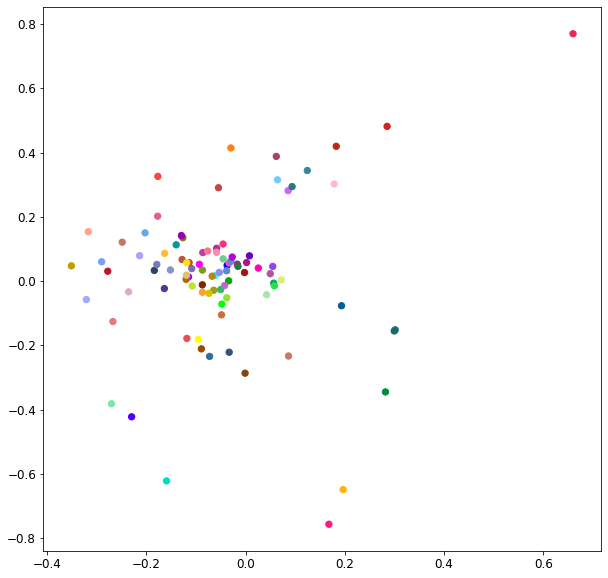

In [41]:
cldf = utils.read_visp_npp_cldf()
h = get_emb(gconv, g, features)

#plot_pca_importance(h, n_hidden)
plot_emb(h, n_hidden, data, cldf, 2, annotation=False, plot_size=(10,10))

In [43]:
from cell import analysis
analysis.get_closest_node_label(h, [str(i) for i in range(93)], "62", 5, cldf )

closest nodes to : Sst Chodl
------------------------------------------

                     cluster_label
cluster_id                        
21                 L6 CT Nxph2 Sla
61               Vip Col15a1 Pde1a
16          L5 PT VISp C1ql2 Ptgfr
20             L5 NP VISp Trhr Met
19           L5 NP VISp Trhr Cpne7


['L6 CT Nxph2 Sla',
 'Vip Col15a1 Pde1a',
 'L5 PT VISp C1ql2 Ptgfr',
 'L5 NP VISp Trhr Met',
 'L5 NP VISp Trhr Cpne7']

In [54]:
analysis.get_closest_node_label(h, [str(i) for i in range(93)], "14", 5, cldf )

closest nodes to : L5 PT VISp Chrna6
------------------------------------------

                   cluster_label
cluster_id                      
83                  Pvalb Gabrg1
23          L6 CT VISp Nxph2 Wls
18              L5 PT VISp Krt80
1           L2/3 IT VISp Adamts2
46              Vip Igfbp6 Car10


['Pvalb Gabrg1',
 'L6 CT VISp Nxph2 Wls',
 'L5 PT VISp Krt80',
 'L2/3 IT VISp Adamts2',
 'Vip Igfbp6 Car10']

In [82]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

emb = h
dist = squareform(pdist(emb))
dist = pd.DataFrame(dist, index=[str(i) for i in range(93)], columns=[str(i) for i in range(93)])
dist.values[np.arange(dist.shape[0]),np.arange(dist.shape[0])] = dist.max(axis=1)
idx = np.argsort(dist.loc['1'].tolist())
# sorted_indices = [index[i] for i in idx]

In [53]:
cldf[cldf.subclass_label == "L5 PT"]

,dendcluster_id,cluster_label,colors,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color
cluster_id,,,,,,,,,,
14,29,L5 PT VISp Chrna6,#0000FF,#0000FF,11,L5 PT,#0D5B78,2,Glutamatergic,#27AAE1
15,30,L5 PT VISp Lgr5,#22737F,#22737F,11,L5 PT,#0D5B78,2,Glutamatergic,#27AAE1
16,31,L5 PT VISp C1ql2 Ptgfr,#247740,#247740,11,L5 PT,#0D5B78,2,Glutamatergic,#27AAE1
17,32,L5 PT VISp C1ql2 Cdh13,#00A863,#00A863,11,L5 PT,#0D5B78,2,Glutamatergic,#27AAE1
18,33,L5 PT VISp Krt80,#29E043,#29E043,11,L5 PT,#0D5B78,2,Glutamatergic,#27AAE1


In my opinion, this method is less dependent on the